# Computing a Best Fit Line

Penn State University provides a [very practical course in regression methods](https://onlinecourses.science.psu.edu/stat501/) along with simple, easy to use examples. I found this course to be a good refresher on regression, but it stopped at the point of going under the hood to execute the machine learning to find best fit lines. In this notebook, I demonstrate a few examples of the higher-level stats using Python/NumPy/SK/what have you. I then go a step further and walk through the machine learning aspects that make Python purr. 

(add'l credits: @mattnedrich for this [blog post](https://spin.atomicobject.com/2014/06/24/gradient-descent-linear-regression/) that was wicked helpful)

In [132]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

The cancer data set shows mortality rates by state for skin cancer victims, along with the center points for latitude and longitude of that state.

In [3]:
cancer = pd.read_table("skincancer.txt", delim_whitespace=True)

In [4]:
cancer.head()

,State,Lat,Mort,Ocean,Long
0,Alabama,33.0,219,1,87.0
1,Arizona,34.5,160,0,112.0
2,Arkansas,35.0,170,0,92.5
3,California,37.5,182,1,119.5
4,Colorado,39.0,149,0,105.5


The NumPy `polyfit()` function computes a least squares polynomial for a given dataset, taking in x and y coordinates and returning a slope and y-intercept. We will soon demonstrate how to do this ourselves.

In [5]:
m_c, b_c = np.polyfit(cancer.Lat, cancer.Mort, 1)

A note for Matplotlib users who are taking advantage of the `%matplotlib inline` declaration: if you're going to overlay a line plot and a scatter plot like this, you have to put them in the same cell. Once `inline` does its thing, you can't overlay a new line on top.

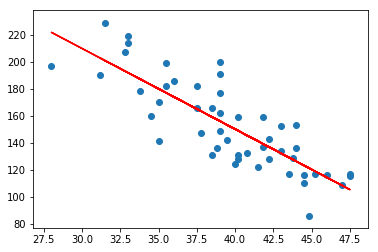

In [6]:
plt.plot(cancer.Lat, [m_c*x + b_c for x in cancer.Lat], "red")
plt.scatter(x=cancer.Lat, y=cancer.Mort)

Same effort as before, just with a new dataset showing the relationship between student height and student weight.

In [7]:
studentheight = pd.read_table("studentheight.txt", delim_whitespace=True)

In [8]:
studentheight.head()

,ht,wt
0,63,127
1,64,121
2,66,142
3,69,157
4,69,162


In [9]:
m_sh, b_sh = np.polyfit(studentheight.ht, studentheight.wt, 1)

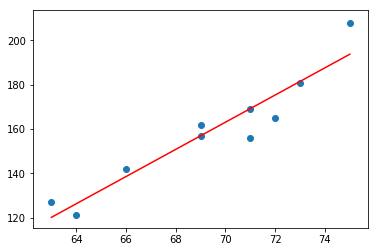

In [10]:
plt.plot(studentheight.ht, [m_sh*x + b_sh for x in studentheight.ht], "red")
plt.scatter(x=studentheight.ht, y=studentheight.wt)

## Least Squares

We can see that our red lines above don't align fully with the $x$ and $y$ values (if they did, we'd have a deterministic relationship rather than a statistical one). The difference between the predicted value ( $\hat{y}_i$ ) and the actual value ( $y_i$ ) is known as the error ( $e_i$ ). Our goal is to find the function such that the sum total of the errors ( $Q$ ) is minimized.

$$Q = \frac{1}{N}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

In order to find the minimum value of $Q$, we're going to use a technique known as [gradient descent.](https://en.wikipedia.org/wiki/Gradient_descent)

The core principles of gradient descent are reasonably simple, even if the execution can turn complex. We are going to try a potential line function, check it for its value of $Q$, then repeat this process for a $n$ number of different attempts until we have the lowest value of $Q$. Though human beings might balk at repeating a computation 10,000 times or 100,000 times, the computer has no issue with this.

We are going to call back to high school algebra and remember that the slope of a line is $m$ and the y-intercept of the line is $b$. Our line will be represented as $y = mx + b$.

In order to execute gradient descent, we first need to determine our error function - which we just did above, with $Q$. Now we need to represent that in code.

In [11]:
def compute_error(b, m, x_data, y_data):
    error = 0
    assert len(x_data) == len(y_data)
    for i, x in enumerate(x_data):
        error += (y_data[i] - (m * x + b)) ** 2
        
    return error / len(x_data)

Why do we call this particular approach "gradient descent," though? Well, let's imagine that $b$ and $m$ are coordinates in a two-dimensional plane, and the error $Q$ is the third dimension. We're looking for the smallest value of $Q$, which we will "descend" toward. This is a little easier to visualize if we plot out a stack of different error values for different values of $b$ and $m$ on the Student Height dataset.

In [119]:
trial_m = []
trial_b = []
trial_Q = []
trial_x = cancer.Lat
trial_y = cancer.Mort

for m in range(-5, 5):
    for b in range(220, 240):
        q = compute_error(b, m, trial_x, trial_y)
        trial_m.append(m)
        trial_b.append(b)
        trial_Q.append(q)

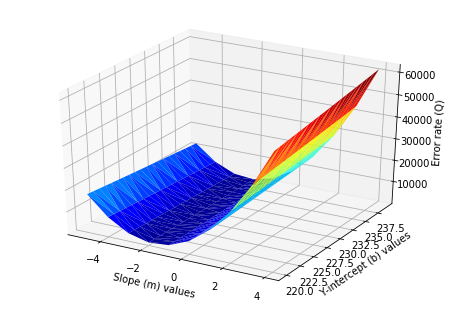

In [120]:
fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel('Slope (m) values')
ax.set_ylabel('Y-intercept (b) values')
ax.set_zlabel('Error rate (Q)')
ax.plot_trisurf(trial_m, trial_b, trial_Q, cmap=cm.jet, linewidth=0.1, vmin=0)

We can see here that the error rates can go horribly wrong (~140K cumulative error on a dataset where the max X value is in the 70s), but the error does have a definitive slope downward. We want values of $m$ and $b$ that are in that darkest blue region - the bottom of the slope.

You may recall from your calculus classes that you can compute the derivative of a function to find the place where the line appears to "bottom out." (or top-out, but that's called gradient ascent) We're going to use that approach here and compute partial derivatives for both $m$ and $b$, then slowly change the values of $m$ and $b$ until we hit our goal.

$$\frac{\delta}{\delta{m}} = \frac{2}{N}\sum_{i=1}^{n}-x_i(y_i-(mx_i+b))$$
$$\frac{\delta}{\delta{b}} = \frac{2}{N}\sum_{i=1}^{n}-(y_i-(mx_i+b))$$

In [122]:
def step_gradient(b_cur, m_cur, x_data, y_data, learning_rate):
    b_gradient = 0
    m_gradient = 0
    N = len(x_data)
    for i in range(0, N):
        m_gradient += -(2/N) * x_data[i] * (y_data[i] - ((m_cur * x_data[i]) + b_cur))
        b_gradient += -(2/N) * (y_data[i] - ((m_cur * x_data[i]) + b_cur))
    
    new_b = b_cur - (learning_rate * b_gradient)
    new_m = m_cur - (learning_rate * m_gradient)
    
    return new_b, new_m

Let's start with a slope ($m$) of 0 and a y-intercept ($b$) of 0 to demonstrate how the algorithm works. We're also going to use a learning rate of 0.01 to adjust our values over time. I'm going to print out the algorithm's status at 10, 50, 5000, 25000, and 125000 iterations so we can see how things change over time.

In [149]:
learning_rate = 0.0005
x_data = cancer.Lat
y_data = cancer.Mort

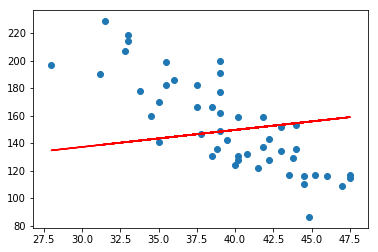

In [150]:
b_10 = 100
m_10 = 1
for i in range(0, 10):
    b_10, m_10 = step_gradient(b_10, m_10, x_data, y_data, learning_rate)
    
plt.plot(x_data, [m_10*x + b_10 for x in x_data], "red")
plt.scatter(x=x_data, y=y_data)

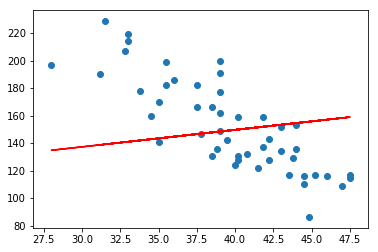

In [151]:
b_50 = 100
m_50 = 1
for i in range(0, 50):
    b_50, m_50 = step_gradient(b_50, m_50, x_data, y_data, learning_rate)
    
plt.plot(x_data, [m_50*x + b_50 for x in x_data], "red")
plt.scatter(x=x_data, y=y_data)

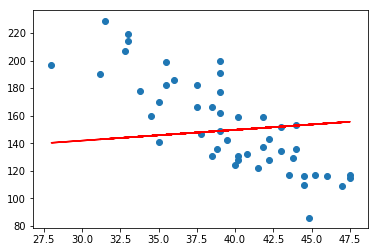

In [152]:
b_5K = 100
m_5K = 1
for i in range(0, 5000):
    b_5K, m_5K = step_gradient(b_5K, m_5K, x_data, y_data, learning_rate)
    
plt.plot(x_data, [m_5K*x + b_5K for x in x_data], "red")
plt.scatter(x=x_data, y=y_data)

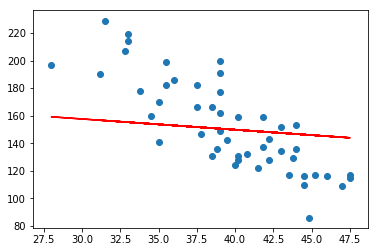

In [153]:
b_25K = 100
m_25K = 1
for i in range(0, 25000):
    b_25K, m_25K = step_gradient(b_25K, m_25K, x_data, y_data, learning_rate)
    
plt.plot(x_data, [m_25K*x + b_25K for x in x_data], "red")
plt.scatter(x=x_data, y=y_data)

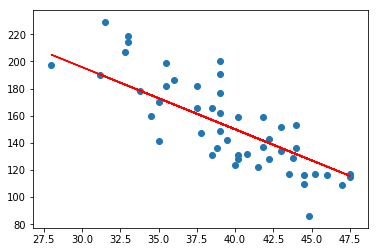

In [154]:
b_125K = 100
m_125K = 1
for i in range(0, 125000):
    b_125K, m_125K = step_gradient(b_125K, m_125K, x_data, y_data, learning_rate)
    
plt.plot(x_data, [m_125K*x + b_125K for x in x_data], "red")
plt.scatter(x=x_data, y=y_data)

Let's bring up the original plot for comparison to see how we're doing:

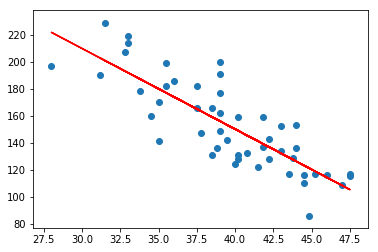

In [155]:
plt.plot(cancer.Lat, [m_c*x + b_c for x in cancer.Lat], "red")
plt.scatter(x=cancer.Lat, y=cancer.Mort)

Not bad! We're a little off, but you can see that both our slope and y-intercept values have been steadily trending in the right direction. With a few more iterations, we'd be right on target!

### Visualizing Error and Variance

Our earlier example has shown how we can use the least squares approach to estimate a line that lets us predict a future value for a given predictor value $x_i$. But how comfortable can we be with the particular prediction our line gives us? 

To illustrate this, let's look at two examples:
* the original student height/weight chart
* a height/weight chart I've slightly modified

In [159]:
studentheight_mod = pd.read_table("studentheightmore.txt", delim_whitespace=True)

In [160]:
studentheight.head()

,ht,wt
0,63,127
1,64,121
2,66,142
3,69,157
4,69,162


In [161]:
studentheight_mod.head()

,ht,wt
0,63,130
1,64,118
2,66,145
3,69,154
4,69,165


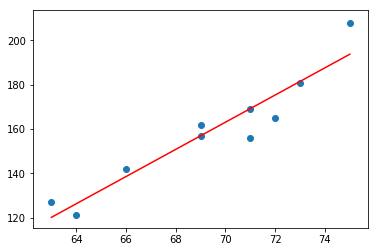

In [162]:
m_sh, b_sh = np.polyfit(studentheight.ht, studentheight.wt, 1)
plt.plot(studentheight.ht, [m_sh*x + b_sh for x in studentheight.ht], "red")
plt.scatter(x=studentheight.ht, y=studentheight.wt)

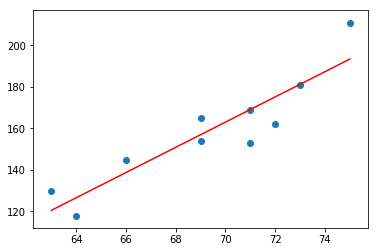

In [163]:
m_sh_mod, b_sh_mod = np.polyfit(studentheight_mod.ht, studentheight_mod.wt, 1)
plt.plot(studentheight_mod.ht, [m_sh_mod*x + b_sh_mod for x in studentheight_mod.ht], "red")
plt.scatter(x=studentheight_mod.ht, y=studentheight_mod.wt)

We can see that the slope and y-intercept of the line is almost exactly the same, but which line is likely to produce a more accurate prediction - the first or the second? The first has more values clustered tightly around the line, meaning any predicted value will likely fall closer to the line.

Recall from earlier statistics classes that a *sample* statistic will be slightly different than a *population* statistic. We don't have the *population* of all students ever here - we just have the *sample* of the students we surveyed. However, that allows us to make some estimates about the *population's* variance based on some of our sample data. That estimate is known as the **mean square error,** and it estimates the population variance $\sigma^2$:

$$\sigma^2 \approx \frac{\sum_{i=1}^{n}(y_i-\hat{y}_i)^2}{n-2}$$

We can compute this number in Python by taking our best-fit line, using it to estimate our predicted values, summing the differences squared, then dividing by $n-2$.

In [164]:
y_values = studentheight.wt
predicted_y_values = [m_sh * x + b_sh for x in studentheight.ht]
assert len(y_values) == len(predicted_y_values)

sum_error = 0
for i, y in enumerate(y_values):
    sum_error += (y - predicted_y_values[i])**2
    
sum_error / (len(y_values)-2)

74.67324402606793

### The Coefficients of Determination and Correlation

Let's jump back to the skin cancer dataset for a minute. We saw with our equations above that we'll *always* get a regression line of some sort. How can we tell if that regression line is *actually* a good predictor of $y$ against $x$, or if any variation is strictly due to random chance?

It turns out that there's a combination of three functions we can build to help us make sense of that data. The first is one we've seen before when inspecting variance:

#### Error Sum of Squares
$$SSE = \sum_{i=1}^{n}(y_i-\hat{y}_i)^2$$

The "error sum of squares" shows us how much the data points $y_i$ vary around the estimated regression line. So, if we build an estimator function, how much error surrounds the data points?

#### Regression Sum of Squares
$$SSR = \sum_{i=1}^{n}(\hat{y}_i-\bar{y}_i)^2$$

The "regression sum of squares" shows us how far the regression line $\hat{y}_i$ differs from the "no relationship line:" $\bar{y}$. $\bar{y}$ is the mean value of all values of $y$.

#### Total Sum of Squares
$$SSTO = \sum_{i=1}^{n}({y}_i-\bar{y}_i)^2$$

The "total sum of squares" shows us how much the actual data points vary from the "no relationship line." It's also conveniently the sum total of the other two functions.

In [165]:
def compute_sse(x_data, y_data):
    # get m and b for the regression line
    est_m, est_b = np.polyfit(x_data, y_data, 1)
    
    # predict y off the regression line
    predict_y = [est_m * x + est_b for x in x_data]
    
    # compute the error sum of squares
    sum_error = 0
    for i, y in enumerate(y_data):
        sum_error += (y - predict_y[i])**2
        
    return sum_error

def compute_ssr(x_data, y_data):
    # get the mean value of all y values
    y_mean = np.mean(y_data)
    
    # get m and b for the regression line
    est_m, est_b = np.polyfit(x_data, y_data, 1)
    
    # predict y off the regression line
    predict_y = [est_m * x + est_b for x in x_data]
    
    sum_r = 0
    for y in predict_y:
        sum_r += (y - y_mean)**2
        
    return sum_r

def compute_ssto(y_data):
    # get the mean value of all y values
    y_mean = np.mean(y_data)
    
    sum_to = 0
    for y in y_data:
        sum_to += (y - y_mean)**2
        
    return sum_to

Let's see what this looks like for a completely random distribution:

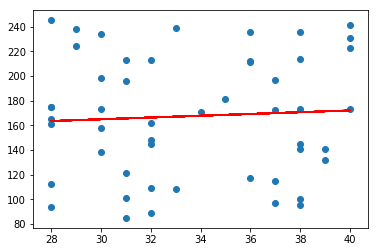

In [179]:
from random import randint

rand_x = [randint(28,40) for x in range(0,50)]
rand_y = [randint(80,250) for x in range(0,50)]

est_m, est_b = np.polyfit(rand_x, rand_y, 1)

plt.plot(rand_x, [est_m*x + est_b for x in rand_x], "red")
plt.scatter(x=rand_x, y=rand_y)

In [181]:
print("SSE: ", compute_sse(rand_x, rand_y))
print("SSR: ", compute_ssr(rand_x, rand_y))
print("SSTO: ", compute_ssto(rand_y))

SSE:  118580.14142417318
SSR:  412.27857582679263
SSTO:  118992.42000000003


Now let's investigate what this looks like for the skin cancer data, where we saw a clear pattern emerging between latitude and mortality:

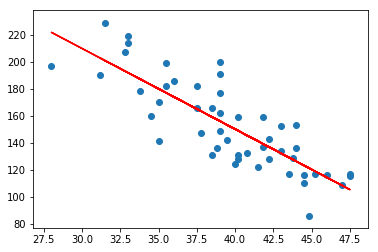

In [182]:
m_c, b_c = np.polyfit(cancer.Lat, cancer.Mort, 1)
plt.plot(cancer.Lat, [m_c*x + b_c for x in cancer.Lat], "red")
plt.scatter(x=cancer.Lat, y=cancer.Mort)

In [183]:
print("SSE: ", compute_sse(cancer.Lat, cancer.Mort))
print("SSR: ", compute_ssr(cancer.Lat, cancer.Mort))
print("SSTO: ", compute_ssto(cancer.Mort))

SSE:  17173.06510312196
SSR:  36464.20020300043
SSTO:  53637.26530612244


We can see clear differences here between the $SSE$ and $SSR$ values for the two datasets. For the completely random dataset, we observe a high $SSE$ value with a relatively $SSR$ value - indicating that most of the change in $y$ is due to random fluctuation of the data rather than a random pattern.

For the cancer dataset, however, we observe a much higher $SSR$ value compared to the $SSE$ value. This is also expected, as much more of our changes in $y$ (skin cancer mortality) can be explained in changes in $x$ (state latitude).

We boil all this down into a "coefficient of variation," or the percentage of the data fluctuation in $y$ that can be explained by changes in $x$:

$$r^2 = \frac{SSR}{SSTO}$$

For our two datasets, that looks like:

In [187]:
print("Coefficient of determination (random): " 
      + str(compute_ssr(rand_x, rand_y)/compute_ssto(rand_y)))
print("Coefficient of determination (skin cancer): " 
      + str(compute_ssr(cancer.Lat, cancer.Mort)/compute_ssto(cancer.Mort)))

Coefficient of determination (random): 0.0034647465429040987
Coefficient of determination (skin cancer): 0.6798295922599583


We can see here that the skin cancer dataset has a far higher coefficient of determination than the completely random one - in line with expectations.

The coefficient of correlation ($r$) is similar to the coefficient of determination ($r^2$) and can be computed in the expected way. Unlike determination, though, correlation has a positive *or* negative value - indicating how the relationship between $x$ and $y$ plays out. If the coefficient of correlation is a -1, there is a perfect negative linear relationship between $x$ and $y$. If the coefficient of correlation of coefficient is +1, there is a perfect positive linear relationship between $x$ and $y$. Anything else is a matter of degree.

We can compute our coefficient of correlation by breaking out the $SSR$ and $SSTO$ computations in a broader formula:

$$r = \frac{\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2\sum_{i=1}^{n}(y_i-\bar{y})^2}}$$

In [194]:
def compute_r(x_data, y_data):
    x_mean = np.mean(x_data)
    y_mean = np.mean(y_data)
    
    assert len(x_data) == len(y_data)
    
    sum_top = 0
    sum_bottom_x = 0
    sum_bottom_y = 0
    for i in range(0, len(x_data)):
        sum_top += (x_data[i]-x_mean)*(y_data[i]-y_mean)
        sum_bottom_x += (x_data[i]-x_mean)**2
        sum_bottom_y += (y_data[i]-y_mean)**2
        
    return sum_top / (sum_bottom_x * sum_bottom_y)**0.5

In [195]:
print("Coefficient of correlation (random): " 
      + str(compute_r(rand_x, rand_y)))
print("Coefficient of variation (skin cancer): " 
      + str(compute_r(cancer.Lat, cancer.Mort)))

Coefficient of variation (random): 0.05886209767672335
Coefficient of variation (skin cancer): -0.8245177937800735


This tracks with our expectations! Our skin cancer $y$ values are negatively correlated with $x$, and our random dataset is barely corre